CLUSTERING CON INCERTIDUMBRE

Primero, para poder ejecutar el código es necesario instalar los paquetes msotrados. Si no te deja, es necesario indicar en el comando de "pip install" el flag --User o -U

In [1]:
#Packages to install

#!pip install pandas
#!pip install numpy
#!pip install scipy
#!pip install matplotlib
#!pip install scikit-learn
#!pip install ipywidgets

A continuación los imports necesarios. De momento ipywidgtes no es necesario por lo que se puede comentar si da algún tipo de problema

In [172]:
#Imports

import math
import pandas as pd
import numpy as np
import scipy as sp
import random as rd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn import preprocessing

#Interactive plot
#%matplotlib notebook
%matplotlib inline

La primera clase creada es DataSet.

Esta estructura de datos tiene como objetivo facilitar el cargar archivos haciendo uso de la librería pandas. 

En el constructor solo tienes que pasar la ruta de archivo deseada. De momento el código mostrado tiene rutas ed archivo locales y no relativas. Comprobar que las rutas están bien en caso de error.

Para leer el archivo deseado, llamar al método Read el cual incluye como parámetro el carácter de separación, el cual siempre debe ser ','.

La ventaja de esta estructura de datos es que podemos dibujar directamente los puntos del archivo csv.

In [3]:
class DataSet:
    
    data = []
    list_points = []
    drawPoint = []
    
    def __init__(self, file_path):
        self.file_path = file_path
        
    #Derived
    def Read(self, sep):
        self.data = pd.read_csv(self.file_path, sep=sep,encoding='utf8')
        
        points = []
        allX = []
        allY =[]
        
        for index, row in self.data.iterrows():
            p = Point(row['Coord X'],row['Coord Y'])
            points.append(p)
            allX.append(p.x)
            allY.append(p.y)
            
        self.list_points = points
        self.drawPoint.append(allX)
        self.drawPoint.append(allY) 
        
    def DrawData(self, drawType):       
        plt.plot(self.drawPoint[0],self.drawPoint[1],drawType)

La clase punto siemplemente se encarga de guardar dos valores, las componentes de una coordenada: posición x e y.

In [4]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def getFurthestPoint(self,points):
        
        res = Point(0,0)
        auxDis = 0.0
        
        for i in range(0,len(points)):
            dis = self.CalculateDistanceToPoint(points[i])
            
            if(dis>auxDis):
                auxDis = dis
                res = points[i]
            
        return res
    
    def CalculateDistanceToCluster(self,c):
        dis = self.CalculateDistanceToPoint(c)
        return abs(dis - c.radius)
    
    def CalculateThreshold(self,circles):
        
        distances = []
        distances_n = []
        
        for i in range(0,len(circles)):
            distances.append(self.CalculateDistanceToCluster(circles[i]))
        
        print()
        
        mod = 0.0
        for i in range(0,len(distances)):
            mod += distances[i]
        
        distances_n = np.array(distances)*(1/mod)

        return distances_n
    
    def CalculatePerpendicular(self,p):
        #Punto medio
        xMean = (self.x + p.x)/2
        yMean = (self.y + p.y)/2
        
        #Pendiente usando: y - y1 = m(x - x1) y  mp = -1/m
        m = -1/((p.y - self.y)/(p.x - self.x))
        
        #Se devuelve [x,y,b]
        perpendicular = ([-m,1,m*(-xMean)+yMean])
        
        return perpendicular
    
    def CalculateDistanceToPoint(self,p):
        disX = p.x - self.x
        disY = p.y - self.y
        dis = math.sqrt(disX*disX + disY*disY)
        
        return dis

La clase círculo como su nombre bien indica es una estructura de datos encargada de gestionarlo.

Contiene la información del centro de la circunferencia, radio, numero de putnos que se compone y sus valores en coordenadas.

En el constructor simplemente se pasa el centro, radio y número de puntos deseados. 

El método Update simplemente modifica los valores de centro y radio.

El método Draw se limita a realizar un esbozo del círculo.

In [5]:
class Circle:
    
    center = 0
    readius = 0
    numOfPoints = 0
    xVals = []
    yVals = []
    
    def __init__(self, center, radius, numOfPoints):
        self.center = center
        self.radius = radius
        self.numOfPoints = numOfPoints
        self.__Calculate()
      
    #Derived
    def __Calculate(self):
        
        self.xVals = []
        self.yVals = []
        
        alpha = 2*math.pi/self.numOfPoints
        i = 0     
        while i < 2*math.pi:
            self.xVals.append(self.center.x + self.radius*math.cos(i))
            self.yVals.append(self.center.y + self.radius*math.sin(i))
            i += alpha
            
    def Update(self, center, radius):
        self.center = center
        self.radius = radius
        self.__Calculate()
    
    def Draw(self):
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            plt.plot(xPrimeVals,yPrimeVals)
            plt.plot(self.center.x,self.center.y,'bo')
            
    def CalculateFrom3Points(p1,p2,p3):
        #Mediatrices
        perp1 = p1.CalculatePerpendicular(p2)
        perp2 = p1.CalculatePerpendicular(p3)
        
        #Circuncentro
        A = [[perp1[0],perp1[1]],[perp2[0],perp2[1]]]
        
        if(np.linalg.det(A)==0):
            return Point(0,0),-1
        else:
            B = [[perp1[2]],[perp2[2]]]
            X = np.linalg.solve(A,B)
            circumcenter = Point(X[0],X[1])

            #Radio
            radius = circumcenter.CalculateDistanceToPoint(p1)

            return circumcenter, radius

La Clase canvas es la que usaremos principalmente para visualziar los datos.

Recibe como parámetro una altura, anchura y datos.

Lo más importante de esta clase es el transformar los Datos a Puntos del que se encarga el método privado "__DataToPoints".

Luego tenemos más métodos:

DrawData(): Simplemente dibuja los puntos que se han pasado en el constructor

RemoveRandomPoints(percentage): Para eliminar puntos de los datos. Indica el porcentaje de los puntos que quieran ser borrados, de forma aleatoria.

InsertNoise(devX,devY): Para añadir ruido a los datos. Se pasa como parámetro la desviación que queremos tanto en la X como en la Y

Luego tenemos dos métodos para generar circunferencias alteatorias con el objetivo de generar Datos.

DrawRandomCircles_r(numOfCircles, precision): Genera circufnerencias aletatoris con un radio alteatorio. Genera tantas circufnerencias como se indique en el parámetro de la función

DrawRandomCircles(numOfCircles, minRadius, maxRadius, precision): Igual que "DrawRandomCircles_r" pero además indicando las longitudes del radio que deseemos.

In [6]:
class Canvas:
    
    width = 0
    height = 0
    data = []
    points = []
    
    def __init__(self, width, height, data):
        self.width = width
        self.height = height
        self.data = data
        self.points = self.__DataToPoints()
   
    #Derived
    def __DataToPoints(self):
        res = []        
        for i in range (0,len(self.data)):            
            for j in range(0,self.data[i].numOfPoints):                
                point=[]
                point.append(self.data[i].xVals[j])
                point.append(self.data[i].yVals[j])              
                point.append("Circulo"+str(i+1))
                
                res.append(point)
        return res
    
    def DrawData(self):
        for i in range (0,len(self.points)):
            plt.plot(self.points[i][0],self.points[i][1],'ro')
    
    def RemoveRandomPoints(self,percentage):
        
        if len(self.points) != 0:
            pointsToRemove = int(len(self.points)*percentage)
            newArrayLen = len(self.points)

            for i in range (0, pointsToRemove):
                j = rd.randint(0,newArrayLen-1)
                self.points.pop(j)
                newArrayLen -= 1
        else:
            print("Data debe tener al menos un punto.")
    
    def InsertNoise(self,devX,devY):
        noiseX = np.random.normal(0,devX,len(self.points))
        noiseY = np.random.normal(0,devY,len(self.points))
        
        for i in range(0,len(self.points)):
            self.points[i][0] += noiseX[i]
            self.points[i][1] += noiseY[i]
            
    def DrawRandomCircles_r(self,numOfCircles, precision):
            
        for i in range (0,numOfCircles):
            
            maxRad = 0
            
            if(self.width > self.height):
                maxRad = self.height/2
            else:
                 maxRad = self.width/2
            
            radius = rd.uniform(1,maxRad)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)
                       
            c = Circle(Point(centerX,centerY),radius,precision)
            self.data.append(c)
            c.Draw()
        
        self.points = self.__DataToPoints()
            
    def DrawRandomCircles(self,numOfCircles, minRadius, maxRadius, precision):
            
        for i in range (0,numOfCircles):
                       
            radius = rd.uniform(minRadius,maxRadius)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)                       
            c = Circle(Point(centerX,centerY),radius,precision)
            
            self.data.append(c)
            c.Draw()
            
        self.points = self.__DataToPoints()

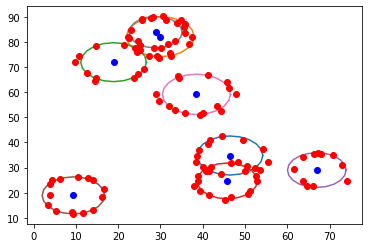

In [534]:
canvas2 = Canvas(100,100,[])
canvas2.DrawRandomCircles(8,5,10,20)
canvas2.RemoveRandomPoints(0.3)
canvas2.InsertNoise(1,0.2)
canvas2.DrawData()
headers = ['Coord X','Coord Y', 'Circulo']
df = pd.DataFrame(canvas2.points, columns= headers)

In [8]:
file_path = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_xport.csv"
df.to_csv(file_path, columns=headers, index=False, encoding="utf8")

NameError: name 'df' is not defined

In [535]:
setDatos = DataSet(file_path)
setDatos.Read(',')

NameError: name 'file_path' is not defined

In [536]:
setDatos.DrawData('ro')

NameError: name 'setDatos' is not defined

Definición del algoritmo segun el pseudocódigo

In [419]:
class ClusteringSolver:
    
    circles = []
     
    def __init__(self,file_path,numCirculo):
        
        self.dataSet = DataSet(file_path)
        self.dataSet.Read(',')
        
        for i in range (0,numCirculo):
            radius = rd.uniform(2,10)
            centerX = rd.uniform(10,90)
            centerY = rd.uniform(10,90)
                       
            c = Circle(Point(centerX,centerY),radius,20)
            
            self.circles.append(c)
    
    def CalculateThreshold(self):
        
        threshold = []
        
        for i in range(0,len(self.dataSet.list_points)):
            p = self.dataSet.list_points[i]
            threshold.append(p.CalculateThreshold(self.circles))
    
        return threshold
    
    def CalculateBestFitPoints(self,listOfPoints):     
        index = round(len(listOfPoints)/3)
        return listOfPoints[0],listOfPoints[index],listOfPoints[index*2]
    
    def CalculateCircunference(self,listOfPoints):
        radius = -1
        while radius == -1:
            p1,p2,p3 = self.CalculateBestFitPoints(listOfPoints)
            center, radius = Circle.CalculateFrom3Points(p1,p2,p3)  

        return center, radius

In [8]:
file_path = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_xport.csv"
cs = ClusteringSolver(file_path,8)
print(cs.dataSet.data)

       Coord X    Coord Y   Circulo
0    91.617966  39.315935  Circulo1
1    90.679180  41.712500  Circulo1
2    86.040145  45.649173  Circulo1
3    83.739861  47.583805  Circulo1
4    83.179295  47.522019  Circulo1
..         ...        ...       ...
107  34.154941  38.452775  Circulo8
108  33.555362  35.929366  Circulo8
109  36.867133  33.821016  Circulo8
110  48.241221  33.547835  Circulo8
111  55.245566  38.860694  Circulo8

[112 rows x 3 columns]


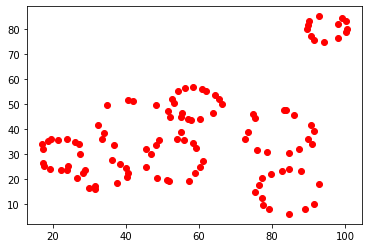

In [9]:
cs.dataSet.DrawData('ro')

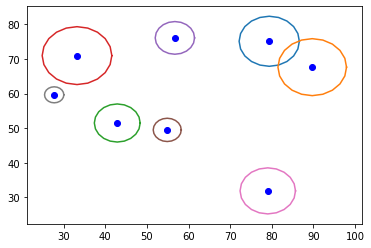

In [10]:
for i in range (0,len(cs.circles)):
    cs.circles[i].Draw()

In [11]:
print(len(cs.circles))

8


In [12]:
#thresh = cs.CalculateThreshold()

     Coord X   Coord Y   Circulo
0   9.824506  5.205249  Circulo1
1   9.965261  5.248728  Circulo1
2   9.629603  6.190948  Circulo1
3   9.673871  7.188207  Circulo1
4   8.694947  7.689930  Circulo1
5   8.843908  8.208364  Circulo1
6   8.038154  8.897284  Circulo1
7   6.168455  9.446737  Circulo1
8   5.841774  9.986368  Circulo1
9   5.122585  9.926931  Circulo1
10  4.147660  9.648467  Circulo1
11  2.473193  9.555514  Circulo1
12  2.202340  9.294412  Circulo1
13  1.566561  8.893732  Circulo1
14  1.517396  8.282985  Circulo1
15  0.590616  7.164255  Circulo1
16  0.299256  6.105135  Circulo1
17  0.181191  5.677704  Circulo1
18  0.063987  4.994135  Circulo1
19  0.236883  4.286715  Circulo1
20  0.072090  3.750488  Circulo1
21  0.030808  2.417025  Circulo1
22  1.045844  1.987530  Circulo1
23  1.085113  1.446444  Circulo1
24  1.552725  1.309398  Circulo1
25  2.881083  0.836029  Circulo1
26  3.421772 -0.020497  Circulo1
27  4.906403 -0.062593  Circulo1
28  5.288823 -0.145762  Circulo1
29  5.9560

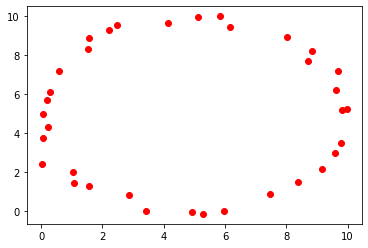

In [311]:
circ = Circle(Point(5,5),5,50)

can = Canvas(100,100,[circ])
can.RemoveRandomPoints(0.3)
can.InsertNoise(0.2,0.2)
can.DrawData()

headers = ['Coord X','Coord Y', 'Circulo']

datfr = pd.DataFrame(can.points, columns= headers)
file_path_c = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_circulo.csv"
datfr.to_csv(file_path_c, columns=headers, index=False, encoding="utf8")

cs2 = ClusteringSolver(file_path_c,0)
points = cs2.dataSet.list_points
print(cs2.dataSet.data)

In [312]:
centro, furthestPoints = cs2.CalculateBestFitPoints(points)
circ = Circle(Point(centro.x,centro.y),5,30)
#can.DrawData()
circ.Draw()

ValueError: too many values to unpack (expected 2)

In [313]:
for i in range(0,len(furthestPoints)):
    print(furthestPoints[i].x,furthestPoints[i].y)

NameError: name 'furthestPoints' is not defined

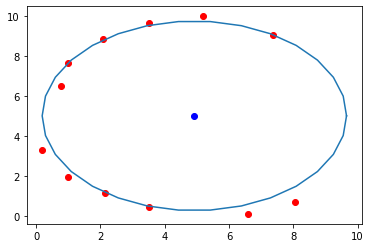

In [533]:
#Calcular circunferencia a partir de un conjunto de puntos

#Creación de puntos a partir de circunferencia
circ = Circle(Point(5,5),5,20)
can = Canvas(100,100,[circ])
can.RemoveRandomPoints(0.4)
can.InsertNoise(0.2,0.2)
can.DrawData()

#Creación de csv con los puntos 
headers = ['Coord X','Coord Y', 'Circulo']
datfr = pd.DataFrame(can.points, columns= headers)
file_path_c = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_circulo.csv"
datfr.to_csv(file_path_c, columns=headers, index=False, encoding="utf8")

#Puntos del problema 
cs2 = ClusteringSolver(file_path_c,0)
points = cs2.dataSet.list_points

#Cálculo circunferencia
c,r = cs2.CalculateCircunference(points)
circ = Circle(c,r,30)

circ.Draw()

In [ ]:
def CalculateBestFitPoints(self,listOfPoints):     
        
        sumX = 0.0
        sumY = 0.0
        distance = 0.0
        auxPoint = []
        auxCenter = 0 
        
        for i in range(0,len(listOfPoints)):
            
            #furthests point from points        
            for j in range(0,len(listOfPoints)):
                actDistance = math.sqrt(pow(listOfPoints[j].x-listOfPoints[i].x,2)+pow(listOfPoints[j].y-listOfPoints[i].y,2))
                if(actDistance > distance):
                    distance = actDistance
                    auxPoint = [listOfPoints[i],listOfPoints[j]]
            
            sumX += listOfPoints[i].x
            sumY += listOfPoints[i].y
        
        p = Point(sumX/len(listOfPoints),sumY/len(listOfPoints))
        
        vecL = Point((auxPoint[0].x+auxPoint[1].x)/2,(auxPoint[0].y+auxPoint[1].y)/2)
    
        newVec = Point(p.x-vecL.x,p.y - vecL.y)
        rect = Point(newVec.y, -newVec.x)
        c = -(rect.x * p.x + rect.y * p.y)
        
        auxVal = 10
        closestPoint = 0
        for j in range(0,len(listOfPoints)):
            
            val = abs(rect.x * listOfPoints[j].x + rect.y * listOfPoints[j].y + c)
            if(j == 0):
                auxVal = val
            else:
                if(val < auxVal):
                    auxVal = val
                    closestPoint = listOfPoints[j]
        
       
        plt.plot(auxPoint[0].x,auxPoint[0].y,'go')
        plt.plot(closestPoint.x,closestPoint.y,'go')
        plt.plot(auxPoint[1].x,auxPoint[1].y,'go')
        
        return p,auxPoint

def preuba_1():
        sumX = 0.0
        sumY = 0.0
        distance = 0.0
        auxPoint = []
        auxCenter = 0 
        
        for i in range(0,len(listOfPoints)):
            
            #furthests point from points        
            for j in range(0,len(listOfPoints)):
                actDistance = math.sqrt(pow(listOfPoints[j].x-listOfPoints[i].x,2)+pow(listOfPoints[j].y-listOfPoints[i].y,2))
                if(actDistance > distance):
                    distance = actDistance
                    auxPoint = [listOfPoints[i],listOfPoints[j]]
            
            sumX += listOfPoints[i].x
            sumY += listOfPoints[i].y
        
        p = Point(sumX/len(listOfPoints),sumY/len(listOfPoints))
        
        dist = math.sqrt(pow(p.x-listOfPoints[0].x,2)+pow(p.y-listOfPoints[0].y,2))
        
        pps=[]
        count = 2
        k = 0
        for i in range(0,len(listOfPoints)-1):
            if(count == 0):
                break
                
            actDistance = math.sqrt(pow(listOfPoints[i].x-listOfPoints[k].x,2)+pow(listOfPoints[i].y-listOfPoints[k].y,2))
            
            if(actDistance >= dist):
                pps.append(listOfPoints[i])
                count-=1
                k = i
                
        return listOfPoints[0],pps[0],pps[1]